In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix

# 1. Set paths and parameters
data_dir = 'dataset'
img_size = (224, 224)
batch_size = 32
num_classes = 4  # cool, neutral, warm, olive

# 2. Augmentation to reduce overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # hold out 20%
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

In [2]:
# 3. Load datasets
train_gen = train_datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    data_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', subset='validation'
)


Found 1193 images belonging to 4 classes.
Found 296 images belonging to 4 classes.


In [3]:
# 4. Build model (transfer learning using MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze pre-trained layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
# 5. Train
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)

# 6. Optionally fine‑tune
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_history = model.fit(train_gen, epochs=5, validation_data=val_gen)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.3752 - loss: 1.4378 - val_accuracy: 0.2500 - val_loss: 1.4449
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.5506 - loss: 1.0655 - val_accuracy: 0.2905 - val_loss: 1.4859
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.7408 - loss: 0.7463 - val_accuracy: 0.2804 - val_loss: 1.6266
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.7483 - loss: 0.6793 - val_accuracy: 0.3311 - val_loss: 1.6243
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8224 - loss: 0.5300 - val_accuracy: 0.3041 - val_loss: 1.7744
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8650 - loss: 0.4390 - val_accuracy: 0.3311 - val_loss: 1.8314
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8612 - loss: 0.3932 - val_accuracy: 0.3480 - val_loss: 1.8994
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8870 - loss: 0.3439 - val_accuracy: 0.3412 - v

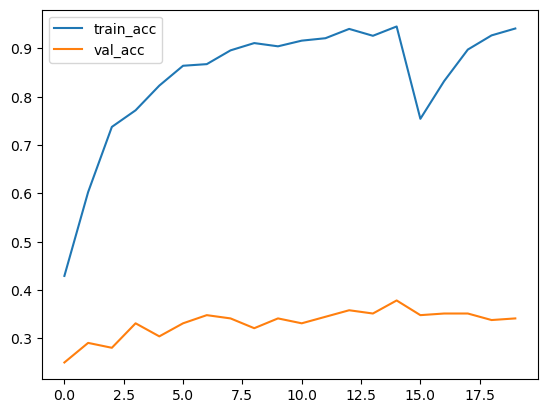

In [5]:

# 7. Save the best model
model.save('undertone_model.h5')

# 8. Plot loss & accuracy curves
plt.plot(history.history['accuracy'] + fine_history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] + fine_history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.show()
